In [1]:
using SerialPorts
using PyPlot
using FFTW

In [2]:
list= list_serialports()

33-element Array{String,1}:
 "/dev/ttyACM1"
 "/dev/ttyS0"  
 "/dev/ttyS1"  
 "/dev/ttyS10" 
 "/dev/ttyS11" 
 "/dev/ttyS12" 
 "/dev/ttyS13" 
 "/dev/ttyS14" 
 "/dev/ttyS15" 
 "/dev/ttyS16" 
 "/dev/ttyS17" 
 "/dev/ttyS18" 
 "/dev/ttyS19" 
 ⋮             
 "/dev/ttyS27" 
 "/dev/ttyS28" 
 "/dev/ttyS29" 
 "/dev/ttyS3"  
 "/dev/ttyS30" 
 "/dev/ttyS31" 
 "/dev/ttyS4"  
 "/dev/ttyS5"  
 "/dev/ttyS6"  
 "/dev/ttyS7"  
 "/dev/ttyS8"  
 "/dev/ttyS9"  

In [3]:
#=================================================================
Empty array
=================================================================#

dummy_one = open("dummy1.txt") do file
    read(file, String)
end

dummy_two = open("dummy2.txt") do file
    read(file, String)
end

dummy_array_one=split(dummy_one, (", "))

dummy_array_two = split(dummy_two, (", "))

#=================================================================#

da1 = []
da2 = []

for i in dummy_array_one
    if (i == "")
        continue
    end
#     println(i)
    push!(da1,parse(Int,i))
end

for i in dummy_array_two
    if (i == "")
        continue
    end
    push!(da2,parse(Int,i))
end

DummyOne = (3.3/4096).*da1
DummyTwo = (3.3/4096).*da2


30000-element Array{Float64,1}:
 1.24716796875     
 1.2495849609374998
 1.248779296875    
 1.2431396484375   
 1.2415283203124998
 1.2423339843749999
 1.2503906249999999
 1.24716796875     
 1.2479736328125   
 1.2463623046874999
 1.2479736328125   
 1.2463623046874999
 1.2431396484375   
 ⋮                 
 1.2439453125      
 1.2455566406249998
 1.2463623046874999
 1.2463623046874999
 1.2463623046874999
 1.24716796875     
 1.2455566406249998
 1.2463623046874999
 1.2463623046874999
 1.2447509765625   
 1.2463623046874999
 1.2455566406249998

In [4]:
#=================================================================
Load matched filter
=================================================================#
matched_one = open("Filter1.txt") do file
    read(file, String)
end

matched_two = open("Filter2.txt") do file
    read(file, String)
end

array_one=split(matched_one, (", "))

array_two = split(matched_two, (", "))

#=================================================================#
ma1 = []
ma2 = []

for i in array_one
    if (i == "")
        continue
    end
    push!(ma1,parse(Int,i))
end

for i in array_two
    if (i == "")
        continue
    end
    push!(ma2,parse(Int,i))
end

MatchOne = (3.3/4096).*ma1
MatchTwo = (3.3/4096).*ma2

for j = 1:length(MatchOne)
    MatchOne[j]=MatchOne[j]-DummyOne[j]
    MatchTwo[j]=MatchTwo[j]-DummyTwo[j]
end


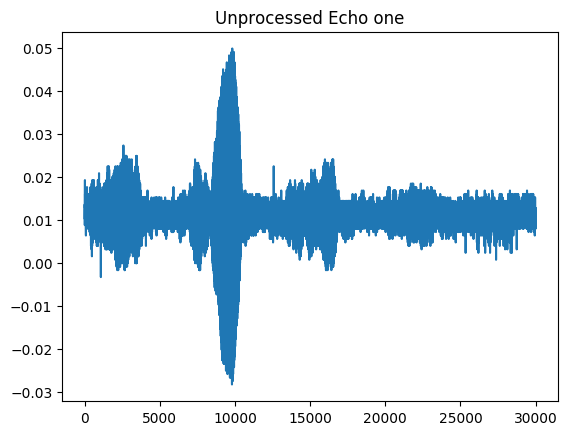

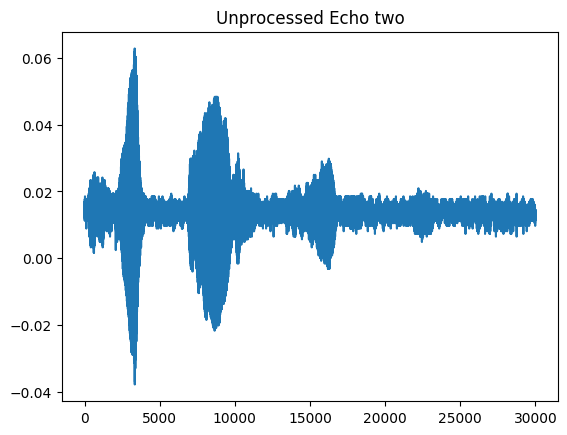

30000
30000


In [6]:
#=================================================================
Receiving prcess
=================================================================#

receive_one = []
receive_two = []

# ser = SerialPort("COM3:", 9600)
ser = SerialPort(list[1], 9600)

readavailable(ser)

#transmit and receive
write(ser, "c")

while bytesavailable(ser) < 1
    continue
end

sleep(0.05)
readavailable(ser) #removes the conversion complete line

#=================================================================#
# Get the first buffer
b = ""
readavailable(ser)

write(ser, "a") # Print DMA buffer
while bytesavailable(ser) < 1
    continue # wait for a response
end

while true
    if bytesavailable(ser) < 2
        sleep(0.005) # Wait and check again
        if bytesavailable(ser) < 1
            break
        end
    end

    global b = string(b, readavailable(ser))

end

receive_one=split(b, ("\r\n"))

#=================================================================#
# Get the second buffer
b = ""
readavailable(ser)

write(ser, "b") # Print DMA buffer
while bytesavailable(ser) < 1
    continue # wait for a response
end

while true
    if bytesavailable(ser) < 2
        sleep(0.005) # Wait and check again
        if bytesavailable(ser) < 1
            break
        end
    end

    b = string(b, readavailable(ser))

end

close(ser)

receive_two=split(b, ("\r\n"))

#=================================================================#
rc1 = []
i=1

while (i<length(receive_one))
    push!(rc1,parse(Int,(receive_one[i])))
    i+=1
end

echo_one = (3.3/4096).*rc1

rc2 = []
i=1

while (i<length(receive_two))
    push!(rc2,parse(Int,(receive_two[i])))
    i+=1
end

echo_2 = (3.3/4096).*rc2


for j = 1:length(echo_one)
    echo_one[j]=echo_one[j]-DummyOne[j]
    echo_2[j]=echo_2[j]-DummyTwo[j]
end

figure("Unprocessed Echo one")
title("Unprocessed Echo one")
plot(echo_one)

figure("Unprocessed Echo two")
title("Unprocessed Echo two")
plot(echo_2)

println(length(echo_one))
println(length(echo_2))

#end of receiving

In [7]:
#=================================================================#

for i = length(MatchOne):34985
    push!(MatchOne,MatchOne[29999])
    push!(MatchTwo,MatchTwo[29999])
    push!(echo_one,echo_one[29999])
    push!(echo_2,echo_2[29999])
end
    
print(length(echo_2))

34986

In [8]:
#=================================================================
 Processing begins
=================================================================#

c = 343;          # Speed of sound in air in m/s
fs = 500000;       # This is the sample rate of the sonar.
dt = 1/fs;        # This is the sample spacing
r_max = 12;        # Maximum range in metres to which to simulate.
t_max = 2*r_max/c;

t = collect(0:dt:t_max);
print(length(t))

# t = t[0:length(y)]
r = c*t/2;

f0 = 40000;       # Centre frequency is 40 kHz
B = 2000;         # Chirp bandwidth
T = 6E-3;         # Chirp pulse length
K = B/T;          # Chirp rate
N = length(t)

34986

34986

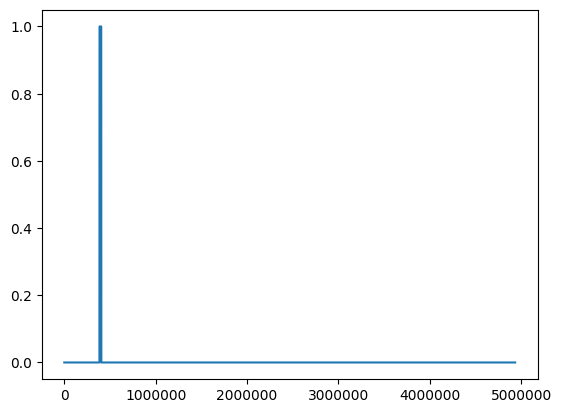

In [9]:
#=================================================================#
# BPF

function rect(t)
    N = length(t)
    x = zeros(N)
    for n = 1:N
        abs_t = abs(t[n])
        if abs_t > 0.5
            x[n] = 0.0
        elseif abs_t < 0.5
            x[n] = 1.0
        else
            x[n] = 0.5
        end
    end
    return x
end
    
δt = dt
δω = 2*pi/(N*dt)
    
ω = 0:δω:(N-1)*δω
f = ω/2*pi

ω0 = f0*2*pi

H = rect((ω.-ω0)/(2*pi*B))+rect((ω.-(ω0.- 2*pi/δt))/(2*pi*B))

figure()
plot(f,H);

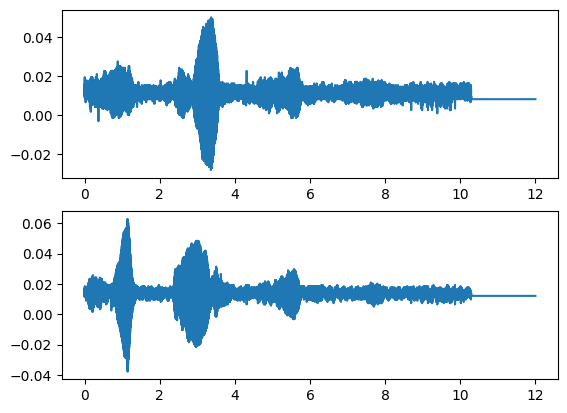

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fef3cd045f8>

In [10]:
#=================================================================
The signals
=================================================================#
#"expected echoes"
v_tx1 = MatchOne
V_TX1 = fft(v_tx1);

v_tx2 = MatchTwo
V_TX2 = fft(v_tx2);

# #plots
# figure("Expected Echo")
# title("Expected Echo")
# subplot(2,1,1)
# plot(r,v_tx1)
# subplot(2,1,2)
# plot(r,v_tx2) #query

# received echos
v_rx1 = echo_one
V_RX1 = H.*(fft(v_rx1));

v_rx2 = echo_2
V_RX2 = H.*(fft(v_rx2));

#plots
figure("Unprocessed Received Echo")
title("Unprocessed Received Echo")
subplot(2,1,1)
plot(r,v_rx1)
subplot(2,1,2)
plot(r,v_rx2) #query


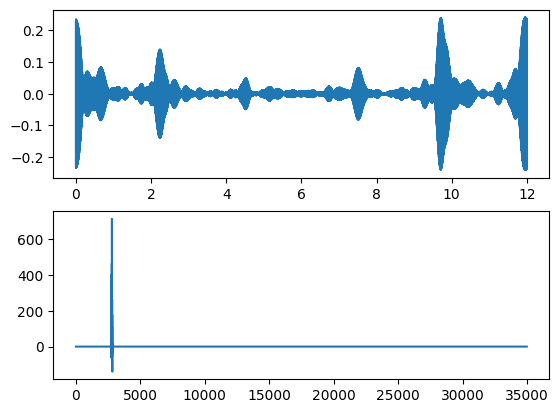

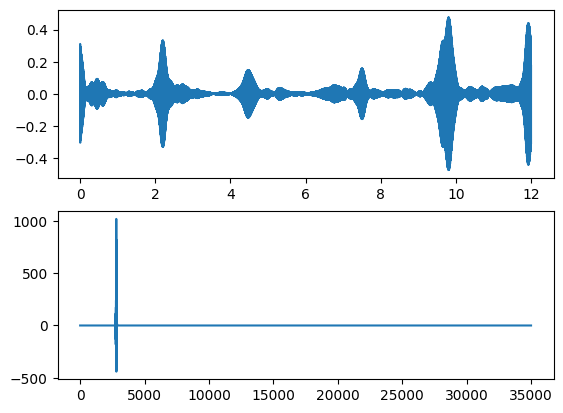

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fef3cc015f8>

In [11]:
#=================================================================
Matched Filering
=================================================================#
#filter one
H1 = conj( V_TX1);

V_MF1 = H1.*V_RX1;
v_mf1 = ifft(V_MF1);

#plots
figure("First Echo match filtered")
title("First Echo match filtered")
subplot(2,1,1)
plot(r,v_mf1)
subplot(2,1,2)
plot(V_MF1) #query

#Filter two
H2 = conj(V_TX2);

V_MF2 = H2.*V_RX2;
v_mf2 = ifft(V_MF2);

#plots
figure("second Echo match filtered")
title("second Echo match filtered")
subplot(2,1,1)
plot(r,v_mf2)
subplot(2,1,2)
plot(V_MF2) #query

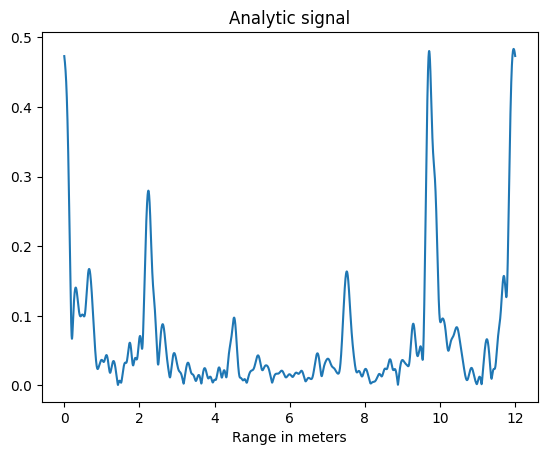

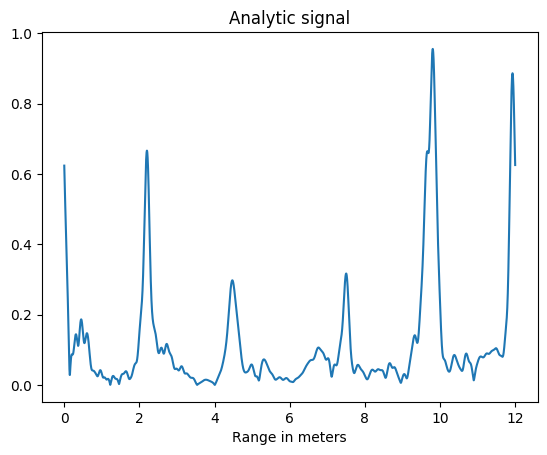

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fef3cbf8d30>

In [12]:
#=================================================================
Analytic Signal
=================================================================#

V_ANAL1 = 2*V_MF1; # make a copy and double the values

if mod(N,2)==0 # case N even
    neg_freq_range = Int(N/2):N; # Define range of “neg-freq” components
else # case N odd
    neg_freq_range = Int((N+1)/2):N;
end

V_ANAL1[neg_freq_range] .= 0; # Zero out neg components in 2nd half of array.
v_anal1 = ifft(V_ANAL1);

#Analytic echo 2

V_ANAL2 = 2*V_MF2; # make a copy and double the values

if mod(N,2)==0 # case N even
    neg_freq_range = Int(N/2):N; # Define range of “neg-freq” components
else # case N odd
    neg_freq_range = Int((N+1)/2):N;
end

V_ANAL2[neg_freq_range] .= 0; # Zero out neg components in 2nd half of array.
v_anal2 = ifft(V_ANAL2);

figure()
title("Analytic signal")
xlabel("Range in meters")
plot(r,abs.(v_anal1))

figure()
title("Analytic signal")
xlabel("Range in meters")
plot(r,abs.(v_anal2))

In [13]:
#=================================================================
Base band Signals
=================================================================#
j=im;

v_bb1 = v_anal1.*exp.(-j*2*pi*f0.*t);
V_BB1 = fft(v_bb1);

v_bb2 = v_anal2.*exp.(-j*2*pi*f0.*t);
V_BB2 = fft(v_bb2);

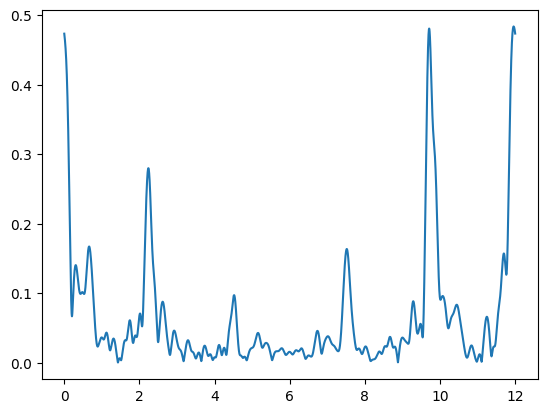

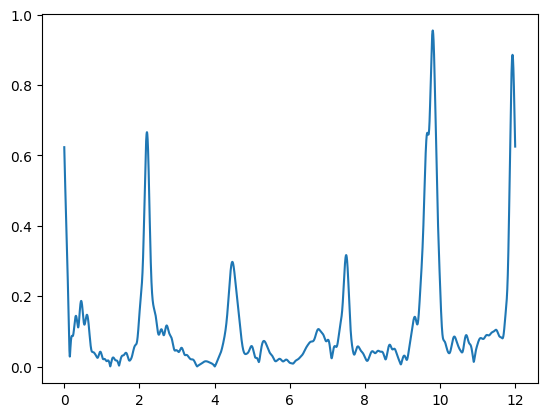

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fef3cadd0b8>

In [14]:
figure()
plot(r,abs.(v_bb1))

figure()
plot(r,abs.(v_bb2))

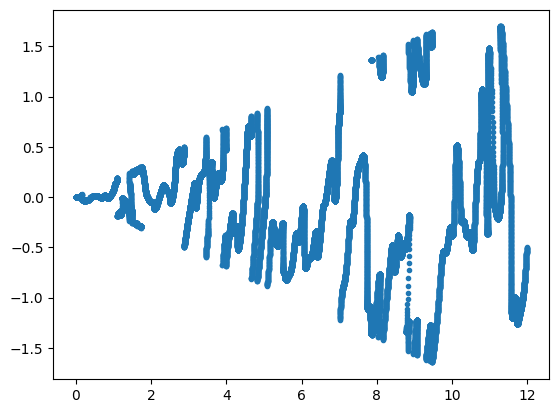

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fef3ca6b048>

In [15]:
d = 0.025
k = 0
λ = c/f0

Δψ = angle.( v_bb2 .* conj(v_bb1))
θ = asin.((λ/(2*pi*d)).* (Δψ.+(k*2*pi)))

x = r.*cos.(θ)
y = r.*sin.(θ)

plot(x,y, ".")